## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import time
import pandas as pd

from AFSParser import build_dataset

# Check for GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyperparams

In [3]:
LR = 1e-4 # learning rate
NUM_ITER = 1001 # number iterations
TV = 1e-2 # total variation regularisation 

Z_NUM = 32 # input seed dimension
NGF = 64 # number of filters per layer
NC = 1 # number of channels

M = 200 # inverse of proportion of given measurements

# Get the data

In [4]:
# Load the data from the file
X, y0 = build_dataset(True, "/scratch/04703/sravula/UTAFSDataNew")

# Choose an s4p example from the dataset (arbitrarily choose the first for now)
X, y0 = torch.from_numpy(X[0]).float(), y0[0].astype(np.float32)

LENGTH = len(X) # number of frequency samples for this s4p chip

kept_samples = range(0, LENGTH, LENGTH//M)
imputed_samples = [x for x in range(LENGTH) if x not in kept_samples]

In [5]:
print("LEN: ", LENGTH)
print("M: ", M)

print(len(kept_samples))
print(len(imputed_samples))

#X is frequency value 
#y is data and has shape [Num timesteps, num series, real/im]
print(X.shape)
print(y0.shape)

print(X[0:5])
print(y0[0:2])

LEN:  1000
M:  200
200
800
torch.Size([1000])
(1000, 10, 2)
tensor([1.0000e+01, 2.0020e+07, 4.0040e+07, 6.0060e+07, 8.0080e+07])
[[[ 1.62895527e-02  3.36585657e-08]
  [ 9.83710468e-01 -1.47077344e-07]
  [ 5.41198300e-04  1.20653327e-08]
  [-5.41198358e-04 -1.01989555e-08]
  [ 1.62895527e-02  6.36966959e-08]
  [-5.41198766e-04 -1.80003799e-08]
  [ 5.41199057e-04  2.83028818e-08]
  [ 1.62859280e-02  4.44385684e-08]
  [ 9.83714044e-01 -1.46876559e-07]
  [ 1.62859280e-02  5.21219015e-08]]

 [[ 2.73069870e-02  1.97834452e-03]
  [ 9.51345623e-01 -1.98990628e-01]
  [ 3.39866988e-03  1.11393863e-02]
  [-1.10015343e-03  1.20446464e-04]
  [ 2.68616639e-02  2.47440138e-03]
  [-1.09024008e-03  1.23698104e-04]
  [ 3.53580643e-03  1.10947918e-02]
  [ 2.72945296e-02  2.16531474e-03]
  [ 9.51394677e-01 -1.98836327e-01]
  [ 2.69166585e-02  2.65295268e-03]]]


# Normalize then graph the data

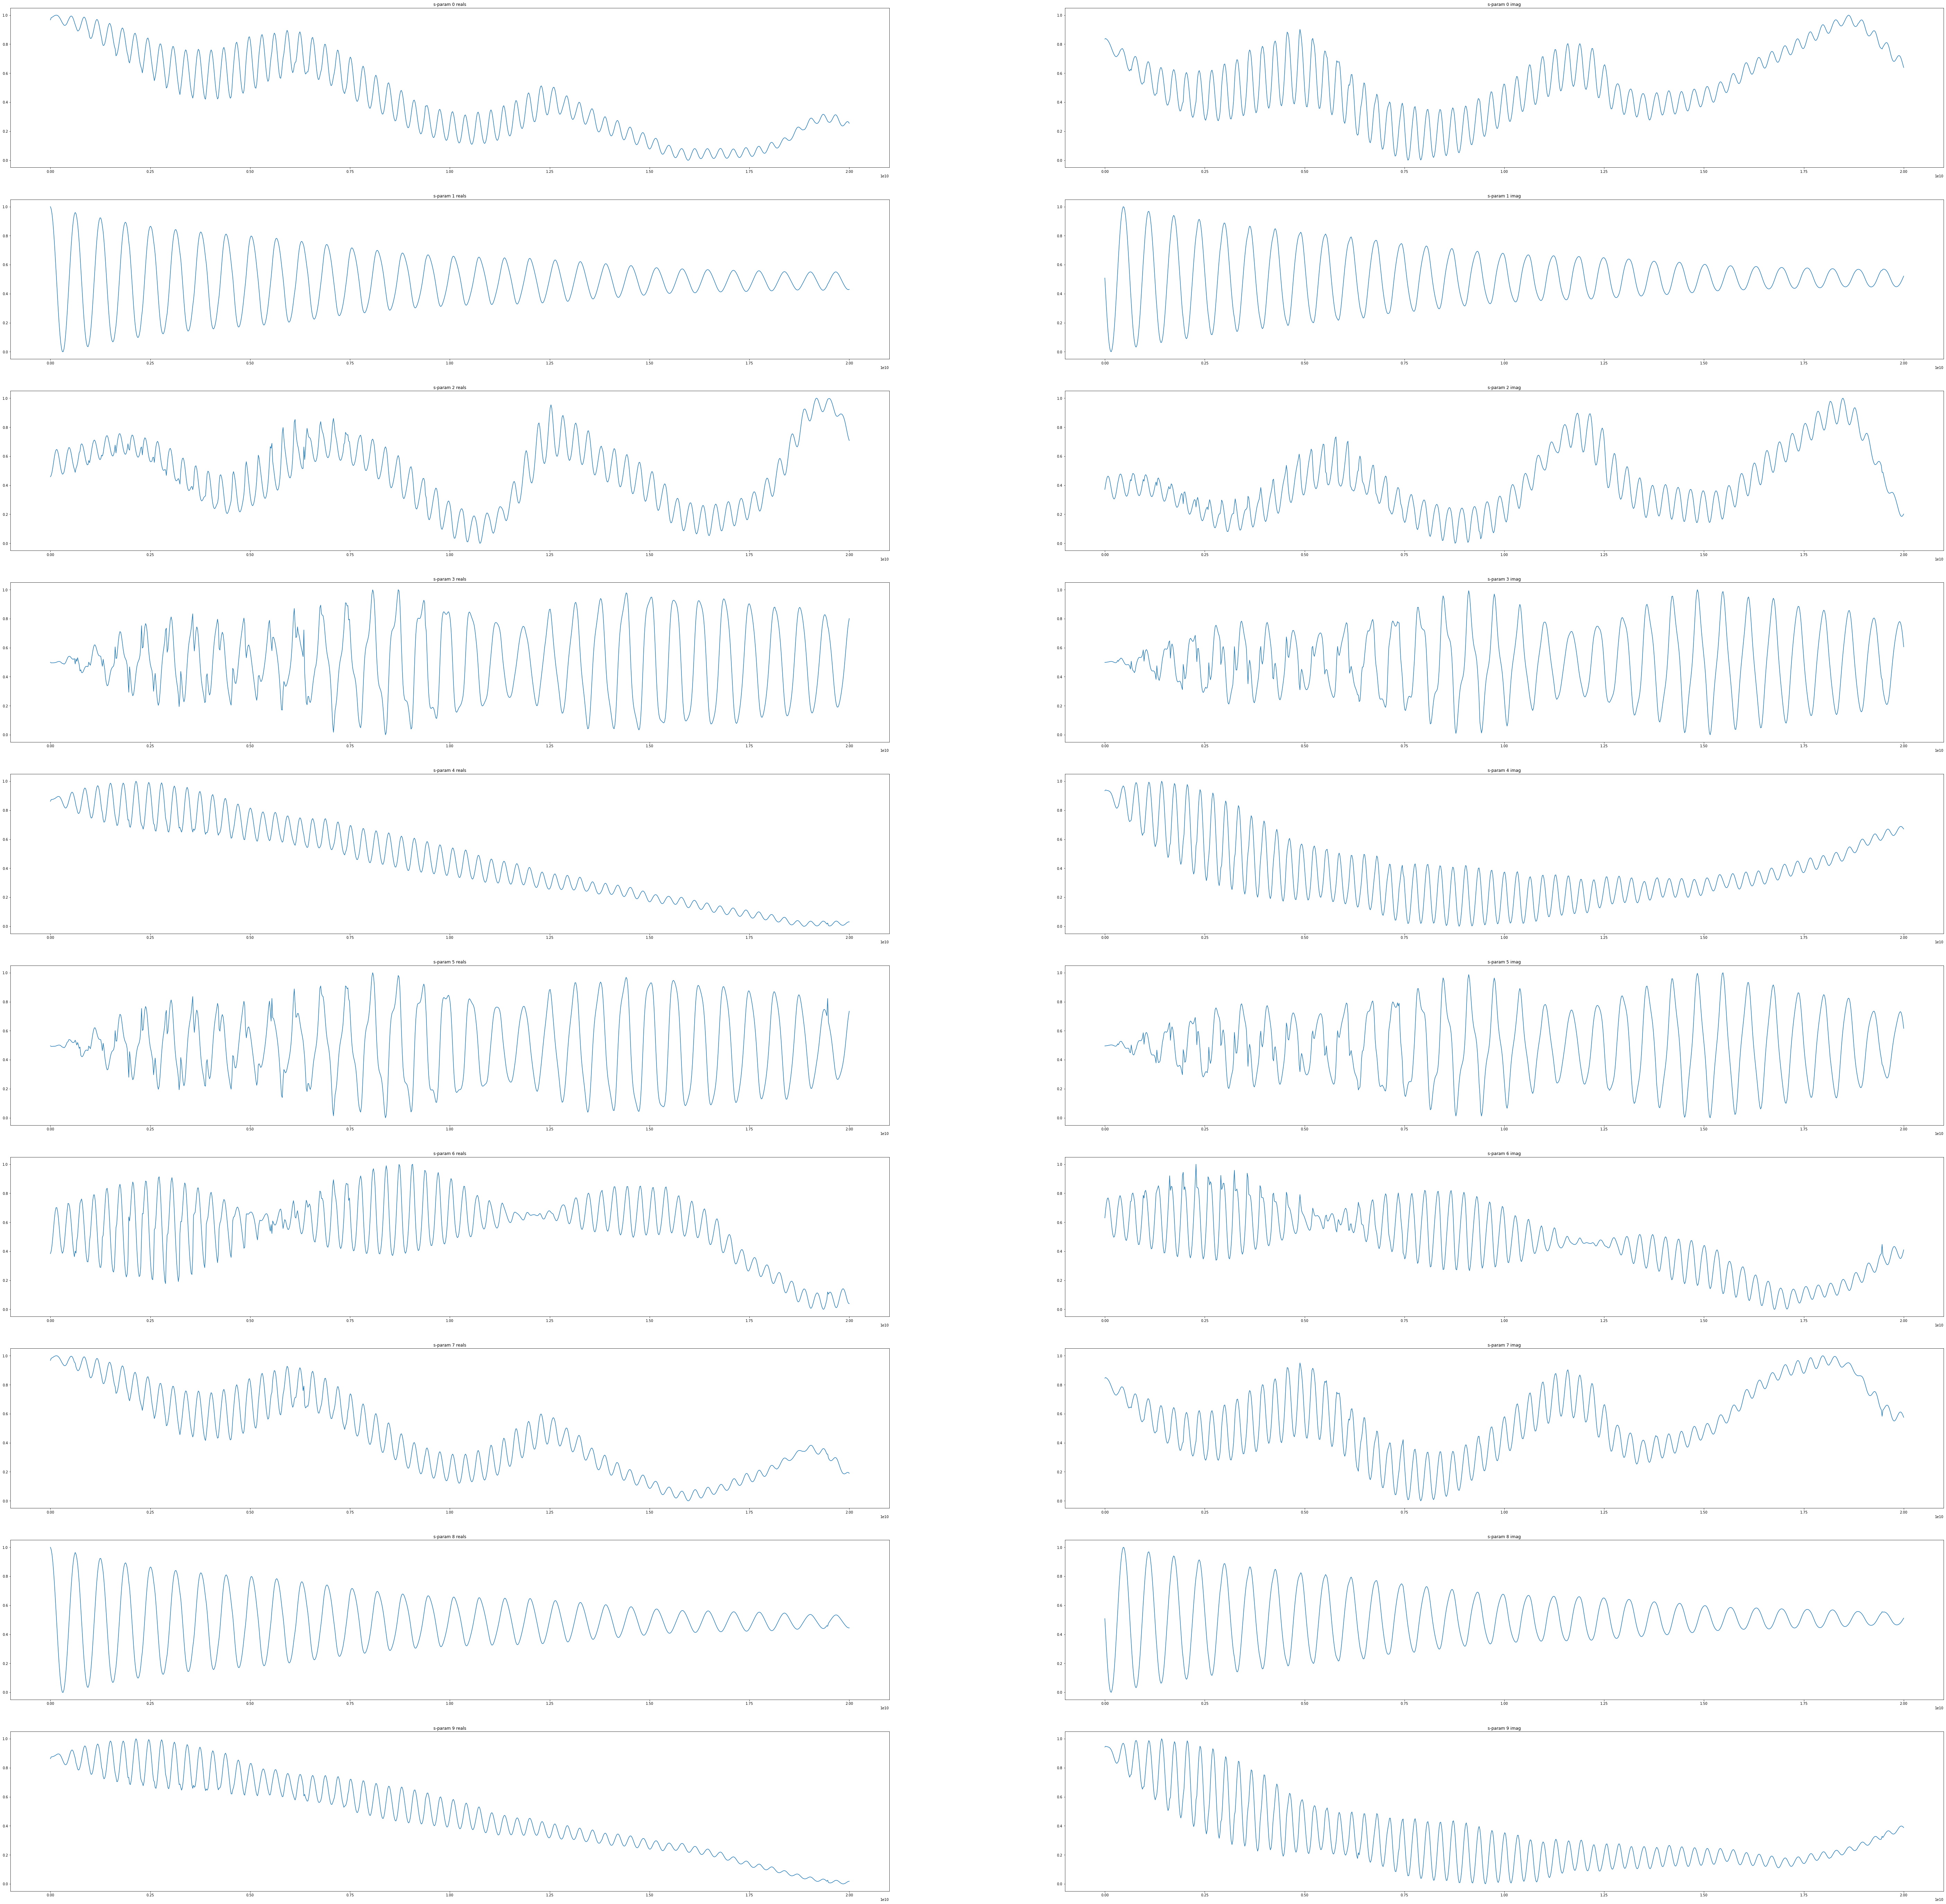

In [6]:
# TODO: Think about what type of normalization is happening here
def normalise(x):
    y = np.squeeze(x)
    
    mins = np.min(y)
    maxs = np.max(y)
    ranges = maxs - mins
    
    return (x - mins)/ranges

y_normalized = np.zeros_like(y0)

# Normalize all of the curves separately
for i in range(10):
    y_normalized[:, i, 0] = normalise(y0[:, i, 0])
    y_normalized[:, i, 1] = normalise(y0[:, i, 1])

figure, axis = plt.subplots(10, 2, figsize=(100, 100))
for i in range(10):
    axis[i, 0].plot(X, y_normalized[:, i, 0]) # The reals for the i'th s-parameter
    axis[i, 0].set_title("s-param " + str(i) + " reals")
    axis[i, 1].plot(X, y_normalized[:, i, 1]) # The reals for the i'th s-parameter
    axis[i, 1].set_title("s-param " + str(i) + " imag")
plt.show()

# For now, just focus on the REAL values of ONE of the s-params for this chip
y_normalized = y_normalized[:, 0, 0]

meas = y_normalized[kept_samples]
y = torch.from_numpy(meas).to(device)

In [7]:
print(y.shape)

torch.Size([200])


# Step 1: Train a model to learn on one curve

Create the network: (currently using default model from 1D-DIP example)

In [8]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=1024, nc=1, num_measurements=64):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size
        self.num_measurements = num_measurements

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm1d(ngf)
        # LAYER 1: input: (random) zϵR^(nzx1), output: x1ϵR^(64x4) (channels x length)

        self.conv2 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm1d(ngf)
        # LAYER 2: input: x1ϵR^(64x4), output: x2ϵR^(64x8) (channels x length)

        self.conv3 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm1d(ngf)
        # LAYER 3: input: x2ϵR^(64x8), output: x3ϵR^(64x16) (channels x length)

        self.conv4 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm1d(ngf)
        # LAYER 4: input: x3ϵR^(64x16), output: x4ϵR^(64x32) (channels x length)

        self.conv5 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm1d(ngf)
        # LAYER 5: input: x4ϵR^(64x32), output: x5ϵR^(64x64) (channels x length)

        self.conv6 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn6 = nn.BatchNorm1d(ngf)
        # LAYER 6: input: x5ϵR^(64x64), output: x6ϵR^(64x128) (channels x length)
        
        self.conv7 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn7 = nn.BatchNorm1d(ngf)
        # LAYER 7: input: x6ϵR^(64x128), output: x7ϵR^(64x256) (channels x length)

        self.conv8 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn8 = nn.BatchNorm1d(ngf)
        # LAYER 8: input: x7ϵR^(64x256), output: x8ϵR^(64x512) (channels x length)

        self.conv9 = nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False)  # output is image
        # LAYER 9: input: x8ϵR^(64x512), output: G(z,w)ϵR^(1x1024) (channels x length)
        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

#         self.output = nn.Linear(1024, output_size * nc, bias=False)
#         # TODO: LAYER 10: not too sure about this, currently taking the output of layer 9 and using linear layer to get correct shape

        self.convout = nn.Conv1d(nc, nc, )

        self.fc = nn.Linear(output_size * nc, num_measurements, bias=False)  # output is A; measurement matrix
        # each entry should be drawn from a Gaussian (random noisy measurements)
        # don't compute gradient of self.fc! memory issues

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
#         x = F.relu(self.conv9(x))
#       x = F.sigmoid(self.output(x)) # Get the output size to match the curve length we expect

        x = self.conv9(x)
        x = F.sigmoid(x[:,:, :self.output_size])

        return x

    def measurements(self, x):
        # this gives the image - make it a single row vector of appropriate length
        y = self.forward(x).view(1, -1)

        # pass thru FC layer - returns A*image
        meas = self.fc(y).view(-1, 1)

        return meas

# Initialize Network

In [9]:
print(Z_NUM, NGF, LENGTH, NC, M)
net = DCGAN(Z_NUM, NGF, LENGTH, NC, M)

net.fc.weight.data = torch.eye(LENGTH)[kept_samples]
net.fc.requires_grad = False

net = net.train()
net = net.to(device)

# Define input seed z as Torch variable, fill with random normal data
z = torch.randn((1, Z_NUM, 1), requires_grad=True, device=device)

allparams = [x for x in net.parameters() if x.requires_grad] #specifies which to compute gradients of
allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive
allparams.append(z)

optim = torch.optim.Adam(allparams, lr=LR)

32 64 1000 1 200


In [10]:
def MSE_TV_LOSS(pred, net_meas, y, alpha_TV):
    TV = torch.sum(torch.abs(pred[:-1, :] - pred[1:, :]))

    mse = torch.nn.MSELoss(reduction='sum')
    MSE = mse(net_meas, y)
    
    output = MSE + alpha_TV * TV

    return output

# Training Loop

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0


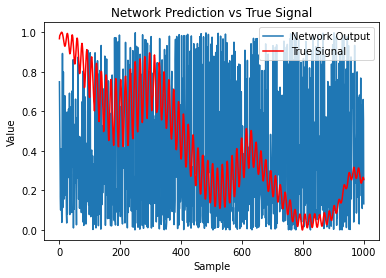

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


100


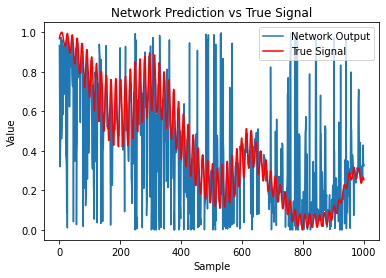

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200


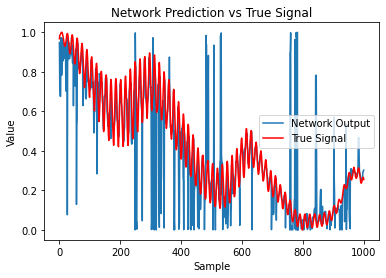

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


300


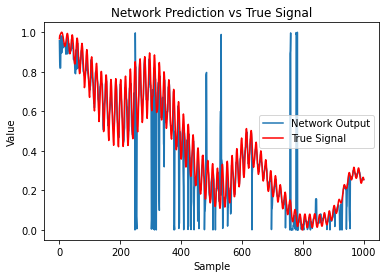

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


400


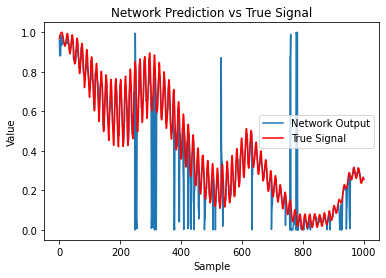

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


500


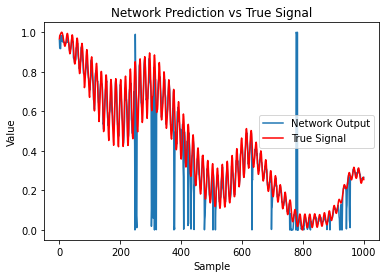

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


600


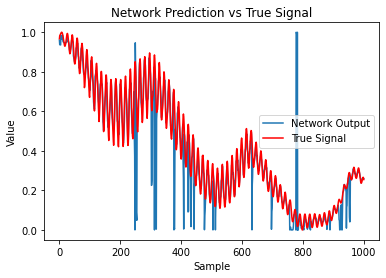

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


700


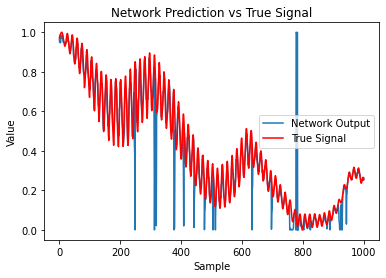

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


800


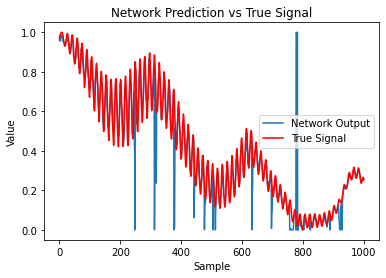

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


900


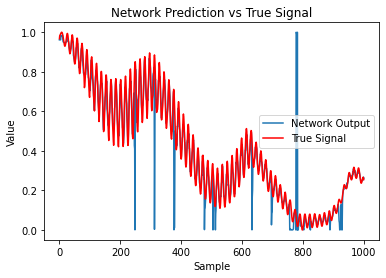

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1000


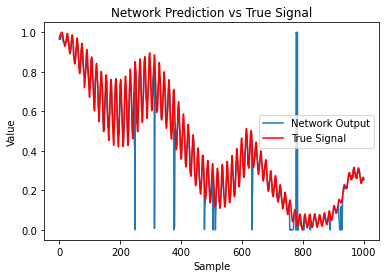

Execution Time:  18.0 s


In [11]:
mse_log_train = np.zeros((NUM_ITER)) #The entire network prediction vs the known measurements
mse_log_test = np.zeros((NUM_ITER)) #The network prediction vs true signal ONLY at unknown values
net_output = np.zeros(LENGTH)

curve = np.zeros((LENGTH, 1))

start = time.time()

for i in range(NUM_ITER):

    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces curve (in form of data tensor) i.e. G(z,w)

    loss = MSE_TV_LOSS(out.view(-1,1), np.squeeze(net.measurements(z)), y, TV) # calculate loss between AG(z,w) and Ay
    loss.backward()
    optim.step()
    
    curve[:,0] = out.data[0].cpu()[0,:] #transfer network output back to cpu to visualize and compare performance

    mse_log_train[i] = np.mean((curve[kept_samples] - meas)**2)
    mse_log_test[i] = np.mean((curve[imputed_samples] - y_normalized[imputed_samples])**2)
    
    if i%100 == 0:
        print(i)
        
        plt.plot(np.arange(LENGTH), curve, label="Network Output")
        plt.plot(np.arange(LENGTH), y_normalized, color='r', label = "True Signal")
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Network Prediction vs True Signal")
        plt.legend()
        plt.show()

    if i == NUM_ITER - 1:
        net_output = curve.squeeze()

end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

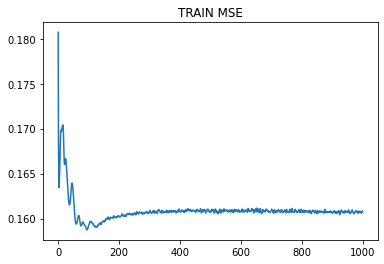

In [12]:
plt.figure()
plt.plot(mse_log_train)
plt.title("TRAIN MSE")
plt.show()

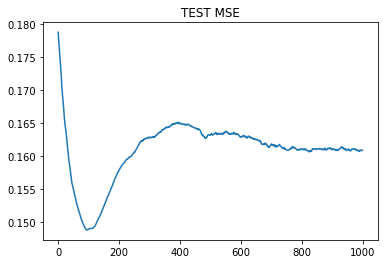

In [13]:
plt.figure()
plt.plot(mse_log_test)
plt.title("TEST MSE")
plt.show()